In [1]:
import pandas as pd
import numpy as np
from utils import break_datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
import joblib
import zipfile
import os
from datetime import datetime, timedelta
import joblib
import zipfile
import os
import wandb


zip_filename = "../dataset/filtered.zip"

# Extract the model file from the ZIP archive
with zipfile.ZipFile(zip_filename, "r") as archive:
    # Extract the model file (named "your_model.pkl" in this example)
    archive.extract("filtered.pkl")
    
# Load the model
df = joblib.load("filtered.pkl")  # Replace with "pickle.load" if you used pickle

os.remove("filtered.pkl")


In [2]:
df['log_meter_reading']=np.log1p(df['meter_reading'])
df = df[["timestamp","site_id","building_id", "log_meter_reading"]]
df = df.groupby(['site_id', 'timestamp'])['log_meter_reading'].mean().reset_index()


In [3]:
data1 = df[df['site_id'] == 1]
data6 = df[df['site_id'] == 6]
data1 = data1.sort_values(by='timestamp').reset_index()
data6 = data6.sort_values(by='timestamp').reset_index()

In [4]:
data1 = data1.drop(axis=1, columns=["index", "site_id"])
data1['timestamp'] = pd.to_datetime(data1['timestamp'])
data1.set_index('timestamp', inplace=True)

data6 = data6.drop(axis=1, columns=["index", "site_id"])
data6['timestamp'] = pd.to_datetime(data6['timestamp'])
data6.set_index('timestamp', inplace=True)

# WandB Site-6

In [5]:
# Function to get the timestamps for the previous and next two days at the same time
def get_surrounding_timestamps(base_timestamp):
    base_date = datetime.strptime(base_timestamp, "%Y-%m-%d %H:%M:%S")
    surrounding_dates = [base_date + timedelta(days=offset) for offset in [-2, -1, 1, 2]]
    return [date.strftime("%Y-%m-%d %H:%M:%S") for date in surrounding_dates]

# Get the surrounding timestamps for August 24 at 14:00 and 15:00
timestamps_14 = get_surrounding_timestamps("2016-08-24 14:00:00")
timestamps_15 = get_surrounding_timestamps("2016-08-24 15:00:00")

# Calculate the averages
average_14 = data6.loc[timestamps_14, 'log_meter_reading'].mean()
average_15 = data6.loc[timestamps_15, 'log_meter_reading'].mean()

# Replace the values in the dataset
data6.at['2016-08-24 14:00:00', 'log_meter_reading'] = average_14
data6.at['2016-08-24 15:00:00', 'log_meter_reading'] = average_15

In [6]:
last_timestamp = data6.index.max()
two_months_ago = last_timestamp - timedelta(days=60)

# Filter the data for the last two months
last_two_months_data6 = data6[two_months_ago:]

In [14]:
wandb.init(project='Moving-Average-Site6', entity='foresquad')

# Define a range of window sizes to test
window_sizes = range(1,2388)  
min_mse = float('inf')
optimal_window_size = None

for window_size in window_sizes:
    # Calculate the moving average using the specified window size
    ma_prediction = data6.loc[:two_months_ago, 'log_meter_reading'].rolling(window=window_size, min_periods=1).mean().iloc[-1]

    # Use this prediction for the last two months
    predicted_values = np.full_like(last_two_months_data6['log_meter_reading'], ma_prediction)

    # Calculate metrics for the last two months
    mae = mean_absolute_error(last_two_months_data6['log_meter_reading'], predicted_values)
    mse = mean_squared_error(last_two_months_data6['log_meter_reading'], predicted_values)
    mape = np.mean(np.abs((last_two_months_data6['log_meter_reading'] - predicted_values) / last_two_months_data6['log_meter_reading'])) * 100
    r2 = r2_score(last_two_months_data6['log_meter_reading'], predicted_values)
    
    if mse < min_mse:
        min_mse = mse
        optimal_window_size = window_size
    # Log metrics to WandB for each window size
    wandb.log({'window_size': window_size, 'MAE': mae, 'MSE': mse, 'MAPE': mape, 'R2': r2})


wandb.log({'optimal_window_size': optimal_window_size, 'minimum_mse': min_mse})
# Close the WandB run
wandb.finish()


MAE,▁▂▃▂▂▃▄▂▁▁▁▂▃▃▃▄▅▅▆▇██▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂
MAPE,▂▂▄▃▃▃▅▃▂▁▁▂▂▃▃▄▄▅▆▇██▇▇▆▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂
MSE,▄▅▇▆▆▆█▆▄▃▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
R2,▅▄▂▃▃▃▁▃▅▆▇███████▇▇▇▇▇▇▇███████████████
minimum_mse,▁
optimal_window_size,▁
window_size,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
MAE,0.09263
MAPE,1.99376
MSE,0.01204
R2,-0.00199


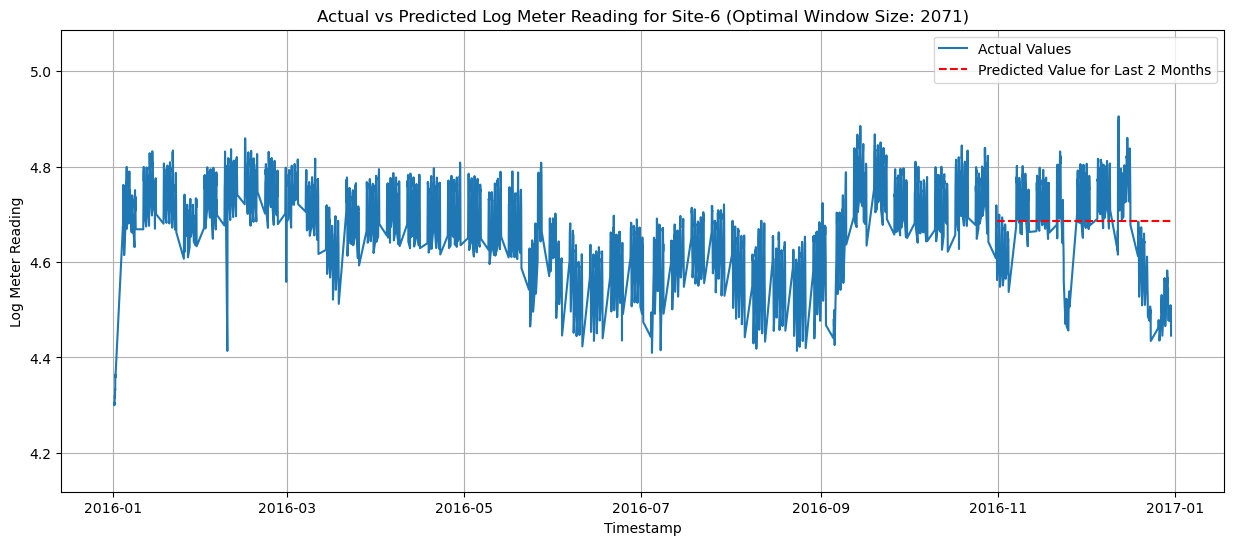

In [16]:
# Assuming 'data6' is the DataFrame we are working with
# Calculate the moving average using the optimal window size
optimal_ma_prediction = data6.loc[:two_months_ago, 'log_meter_reading'].rolling(window=optimal_window_size, min_periods=1).mean().iloc[-1]

# Determine the range for 'log_meter_reading' in data6
log_meter_reading_min = data6['log_meter_reading'].min()
log_meter_reading_max = data6['log_meter_reading'].max()
padding = (log_meter_reading_max - log_meter_reading_min) * 0.3  # 10% padding on each side

# Plotting
plt.figure(figsize=(15, 6))

# Plot the actual values for the entire period from data6
plt.plot(data6.index, data6['log_meter_reading'], label='Actual Values')

# Plot the predicted value line only for the last two months
plt.hlines(y=optimal_ma_prediction, xmin=last_two_months_data6.index[0], xmax=last_two_months_data6.index[-1], colors='r', linestyles='--', label='Predicted Value for Last 2 Months')

plt.title(f'Actual vs Predicted Log Meter Reading for Site-6 (Optimal Window Size: {optimal_window_size})')
plt.xlabel('Timestamp')
plt.ylabel('Log Meter Reading')

# Set the y-axis limits
plt.ylim(log_meter_reading_min - padding, log_meter_reading_max + padding)

plt.legend()
plt.grid(True)
plt.show()


# WandB Site-1

In [11]:
last_timestamp = data1.index.max()
two_months_ago = last_timestamp - timedelta(days=60)

# Filter the data for the last two months
last_two_months_data1 = data1[two_months_ago:]

In [13]:
wandb.init(project='Moving-Average-Site1', entity='foresquad')

# Define a range of window sizes to test
window_sizes = range(1,2388)  
min_mse = float('inf')
optimal_window_size = None

for window_size in window_sizes:
    # Calculate the moving average using the specified window size
    ma_prediction = data1.loc[:two_months_ago, 'log_meter_reading'].rolling(window=window_size, min_periods=1).mean().iloc[-1]

    # Use this prediction for the last two months
    predicted_values = np.full_like(last_two_months_data1['log_meter_reading'], ma_prediction)

    # Calculate metrics for the last two months
    mae = mean_absolute_error(last_two_months_data1['log_meter_reading'], predicted_values)
    mse = mean_squared_error(last_two_months_data1['log_meter_reading'], predicted_values)
    mape = np.mean(np.abs((last_two_months_data1['log_meter_reading'] - predicted_values) / last_two_months_data1['log_meter_reading'])) * 100
    r2 = r2_score(last_two_months_data1['log_meter_reading'], predicted_values)

    if mse < min_mse:
        min_mse = mse
        optimal_window_size = window_size

    # Log metrics to WandB for each window size
    wandb.log({'window_size': window_size, 'MAE': mae, 'MSE': mse, 'MAPE': mape, 'R2': r2})



wandb.log({'optimal_window_size': optimal_window_size, 'minimum_mse': min_mse})
# Close the WandB run
wandb.finish()


MAE,▁▁▂▂▃▄▅▅▅▆▆▆▇▇▇███████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄
MAPE,▁▁▂▂▃▄▅▅▅▆▆▆▇▇▇███████▇▇▇▇▇▆▆▇▆▆▆▆▅▅▅▄▄▄
MSE,▁▁▁▂▂▃▄▄▄▅▅▆▇▇▇▇██████▇▇▆▆▆▆▆▆▆▅▅▅▄▄▃▃▃▃
R2,███▇▇▆▅▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▅▅▆▆▆▆
minimum_mse,▁
optimal_window_size,▁
window_size,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
MAE,0.18311
MAPE,3.93064
MSE,0.04223
R2,-0.21051


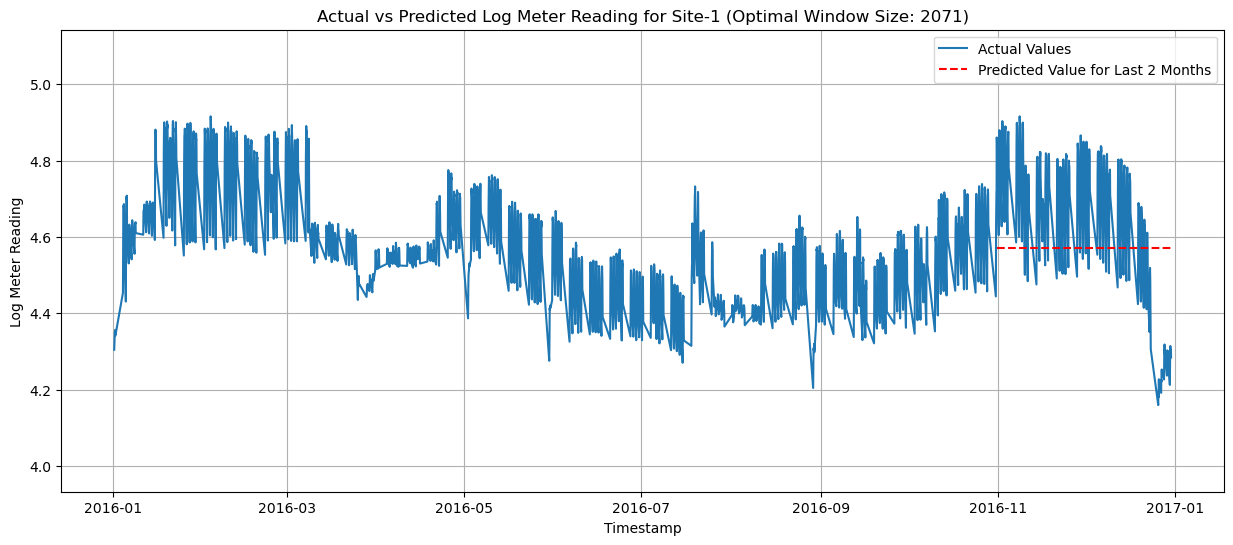

In [18]:
import matplotlib.pyplot as plt

# Assuming 'data1' is the DataFrame we are working with
# Calculate the moving average using the optimal window size
optimal_ma_prediction = data1.loc[:two_months_ago, 'log_meter_reading'].rolling(window=optimal_window_size, min_periods=1).mean().iloc[-1]

# Determine the range for 'log_meter_reading' in data1
log_meter_reading_min = data1['log_meter_reading'].min()
log_meter_reading_max = data1['log_meter_reading'].max()
padding = (log_meter_reading_max - log_meter_reading_min) * 0.3  # 30% padding on each side

# Plotting
plt.figure(figsize=(15, 6))

# Plot the actual values for the entire period from data1
plt.plot(data1.index, data1['log_meter_reading'], label='Actual Values')

# Plot the predicted value line only for the last two months
plt.hlines(y=optimal_ma_prediction, xmin=last_two_months_data1.index[0], xmax=last_two_months_data1.index[-1], colors='r', linestyles='--', label='Predicted Value for Last 2 Months')

plt.title(f'Actual vs Predicted Log Meter Reading for Site-1 (Optimal Window Size: {optimal_window_size})')
plt.xlabel('Timestamp')
plt.ylabel('Log Meter Reading')

# Set the y-axis limits
plt.ylim(log_meter_reading_min - padding, log_meter_reading_max + padding)

plt.legend()
plt.grid(True)
plt.show()
